##### I've selected this model from the previous notebook. This model stood out as the best for having the highest accuracy score and lowest false positives/negatives compared to others.

In [4]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt

# Sklearn Imports
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

# NLTK Imports
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

import warnings

warnings.filterwarnings("ignore")

In [5]:
df = pd.read_csv("../clean_data/clean_combined.csv")
df.shape

(3149, 5)

In [6]:
# Binarize the target column
df["subreddit"] = df["subreddit"].map({"Depression": 0, "Anxiety": 1}).astype("Int64")

#### Text Pre-Processing Function

In [7]:
def preprocess(sentence):
    tokenizer = RegexpTokenizer(r"\w+")
    stop_words = stopwords.words("english")
    p_stemmer = PorterStemmer()

    tokenized = tokenizer.tokenize(sentence)
    no_stop_words = [word for word in tokenized if word.lower() not in stop_words]
    stemmed = [p_stemmer.stem(word) for word in no_stop_words]
    processed = " ".join(stemmed)

    return processed

In [8]:
df["text_processed"] = df["text"].apply(preprocess)

#### Create X and y

In [9]:
X = df["text_processed"]
y = df["subreddit"]

#### Train / Test Split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42, stratify= y)

## Model 1 - TfidfVectorizer and LogisticRegression

In [11]:
pipe = Pipeline([("tfidf", TfidfVectorizer()), ("lr", LogisticRegression(random_state=42))])

pipe_params = {
    "tfidf__max_features": [None],
    "tfidf__stop_words": [None, "english"],
    "tfidf__min_df": [2],
    "tfidf__max_df": [0.8],
    "tfidf__ngram_range": [(1, 3)],
    "lr__penalty": ["l1", "l2", "elasticnet", None],
    "lr__class_weight": [None, "balanced"],
    "lr__C": [10.0],
}

gs = GridSearchCV(pipe, param_grid=pipe_params, cv=10, n_jobs=-1)

gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.8920192246885474
{'lr__C': 10.0, 'lr__class_weight': 'balanced', 'lr__penalty': 'l2', 'tfidf__max_df': 0.8, 'tfidf__max_features': None, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 3), 'tfidf__stop_words': 'english'}


In [12]:
pred = gs.predict(X_test)
print(gs.score(X_train, y_train))
print(gs.score(X_test, y_test))

0.9944422389837237
0.9142857142857143


In [13]:
tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
fp, fn

(20, 34)

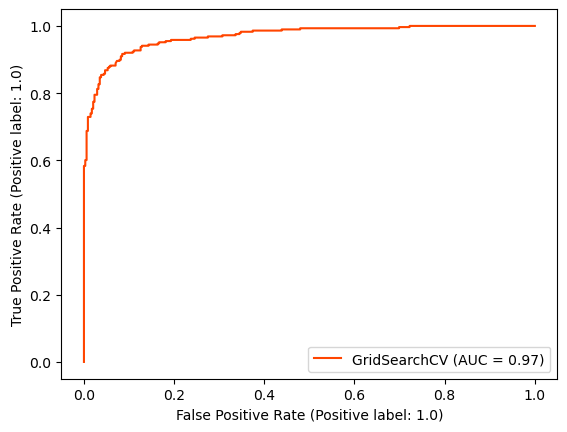

In [18]:
RocCurveDisplay.from_estimator(gs, X_test, y_test, color = '#FF4500')
plt.savefig("../images/roc_curve_plot.png", bbox_inches="tight")

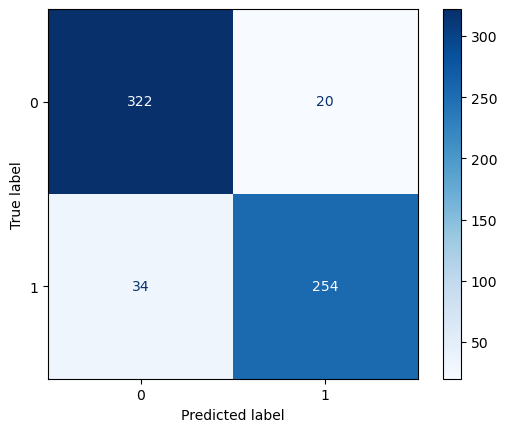

In [15]:
ConfusionMatrixDisplay.from_estimator(gs, X_test, y_test, cmap='Blues')
plt.savefig("../images/confusion_matrix.png", bbox_inches="tight")